In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoModelForImageClassification, AutoFeatureExtractor, TrainingArguments, Trainer

import warnings
warnings.filterwarnings('ignore')

### Загрузка данных с `Huggingface`

In [89]:
dataset = load_dataset("sagecontinuum/smokedataset")

In [90]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 14318
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 3671
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1843
    })
})

In [91]:
# Предобработка изображений
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50")

In [92]:
feature_extractor

ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [94]:
def transform(example):
    example["pixel_values"] = feature_extractor(example["image"], return_tensors="pt")["pixel_values"][0]
    return example

dataset = dataset.map(transform, remove_columns=[])

Map:   0%|          | 0/14318 [00:00<?, ? examples/s]

Map:   0%|          | 0/3671 [00:00<?, ? examples/s]

Map:   0%|          | 0/1843 [00:00<?, ? examples/s]

In [95]:
def collate_fn(batch):
    pixel_values = torch.stack([torch.tensor(example["pixel_values"]) for example in batch])  # Преобразуем список в Tensor
    labels = torch.tensor([example["label"] for example in batch], dtype=torch.long)  # dtype важно для cross-entropy loss
    return {"pixel_values": pixel_values, "labels": labels}

In [96]:
num_classes = len(set(dataset["train"]["label"]))
print(f"Количество классов: {num_classes}, примеры меток: {set(dataset['train']['label'])}")

Количество классов: 3, примеры меток: {0, 1, 2}


In [97]:
# Создание модели
model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-50", num_labels=num_classes, ignore_mismatched_sizes=True)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([3, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
# print(device)
# model.to(device)

In [102]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# Функция для вычисления метрик на каждой эпохе
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)  # Выбираем предсказанный класс

    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [103]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Оценка на каждой эпохе
    save_strategy="epoch",  # Сохранение модели на каждой эпохе
    logging_strategy="epoch",  # Логирование на каждой эпохе
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

In [104]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

In [105]:
# Запуск обучения
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.785200,0.412550,0.957777,0.957898,0.957777,0.957822
2,0.332900,0.170805,0.970308,0.970299,0.970308,0.970242
3,0.244900,0.125588,0.975756,0.975751,0.975756,0.975748


TrainOutput(global_step=2685, training_loss=0.45432276095313956, metrics={'train_runtime': 3592.6199, 'train_samples_per_second': 11.956, 'train_steps_per_second': 0.747, 'total_flos': 9.122250091352187e+17, 'train_loss': 0.45432276095313956, 'epoch': 3.0})

In [106]:
# Оценка на тестовом датасете
eval_results = trainer.evaluate(dataset["test"])
print(eval_results)

{'eval_loss': 0.2468521147966385, 'eval_accuracy': 0.8990775908844275, 'eval_precision': 0.9120514577610034, 'eval_recall': 0.8990775908844275, 'eval_f1': 0.8982059725214997, 'eval_runtime': 98.2545, 'eval_samples_per_second': 18.757, 'eval_steps_per_second': 1.181, 'epoch': 3.0}


### Визуализация результатов

In [109]:
model.to("cpu")

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [115]:
import matplotlib.pyplot as plt

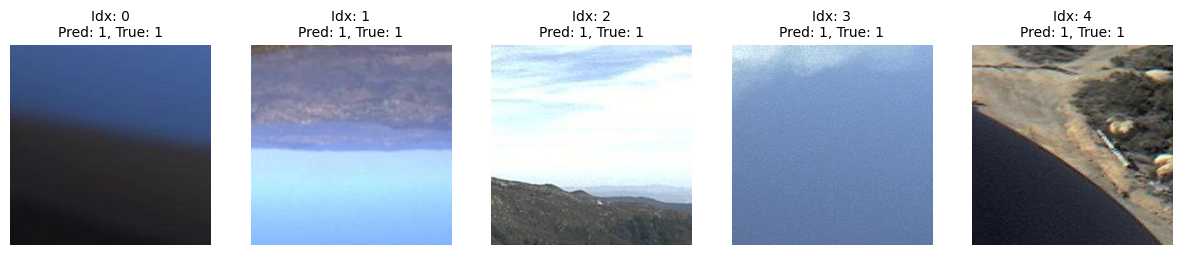

In [113]:
# Функция для предсказания на одном изображении
def predict_image(model, image, feature_extractor):
    model.eval()

    # Преобразуем изображение в формат тензора для модели
    inputs = feature_extractor(image, return_tensors="pt")
    pixel_values = inputs["pixel_values"]

    with torch.no_grad():
        outputs = model(pixel_values)
        logits = outputs.logits
        pred_label = torch.argmax(logits, dim=1).item()  # Выбираем наиболее вероятный класс

    return pred_label

# Функция для отображения предсказаний
def show_predictions(model, dataset, feature_extractor, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        example = dataset["test"][i]  # Берём тестовый образец

        image = example["image"]  # Оригинальное изображение
        true_label = example["label"]

        # Предсказание модели (но используем необработанное image)
        pred_label = predict_image(model, image, feature_extractor)

        # Отображение оригинального изображения
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(f"Idx: {i}\nPred: {pred_label}, True: {true_label}", fontsize=10)

    plt.show()

# Вызываем функцию для отображения предсказаний
show_predictions(model, dataset, feature_extractor)


['image', 'label']


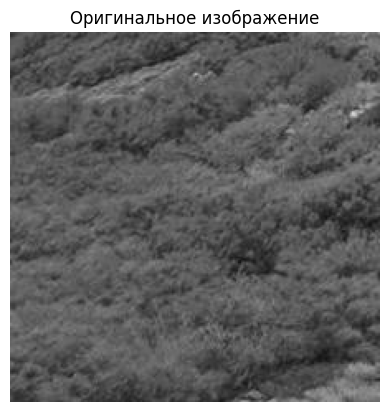

In [80]:
# Повторная загрузка исходного датасета
dataset_original = load_dataset("sagecontinuum/smokedataset")

# Проверяем структуру
print(dataset_original["test"].column_names)

# Восстанавливаем изображение по индексу
idx = 100
image = dataset_original["test"][idx]["image"]

plt.imshow(image)
plt.title("Оригинальное изображение")
plt.axis("off")
plt.show()

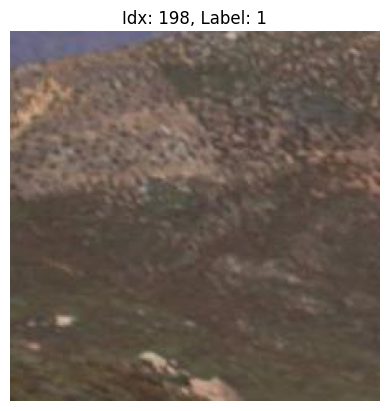

In [120]:
idx = 198# любой индекс
example = dataset["test"][idx]

image = example["image"]
label = example["label"]

plt.imshow(image)
plt.axis("off")
plt.title(f"Idx: {idx}, Label: {label}")
plt.show()